# Tunnel++

***Goal***: To make an improved version of [Location+](https://library.fangraphs.com/pitching/stuff-location-and-pitching-primer/) that incorporates pitch tunneling. <br>
**Author**: Jensen Holm <br>
**Date**: 2024

In [1]:
import statcast_pitches
import polars as pl
from plotnine import *
import os

LOCAL_DATA_DIR = os.path.join("..", "data")

## Loading Data

Using all pitches thrown in the statcast-era (2015-present) as our data for this model. <br>
I will also be using `../data/run_values.csv` for calculating run values of each pitch, this data represents 2024 only.

**Data Dictionary**: [link](https://baseballsavant.mlb.com/csv-docs) <br>
**statcast_pitches package info**: [link](https://github.com/Jensen-holm/statcast-era-pitches) 

In [2]:
pitches_df: pl.LazyFrame = statcast_pitches.load() # default is all pitches

latest_date = pitches_df.select("game_date").max().collect().item().date()
earliest_date = pitches_df.select("game_date").min().collect().item().date()

print(f"N Pitches: {pitches_df.select(pl.len()).collect().item():,}")
print(f"Date Range: {earliest_date} - {latest_date}")

N Pitches: 7,011,927
Date Range: 2015-04-05 - 2024-10-30


In [3]:
run_values_24 = pl.scan_csv(
    os.path.join(LOCAL_DATA_DIR, "run_values.csv"),
).rename({"event": "events"}) # it is called 'events' in pitches_df

## Feature Engineering

adding the following features to `pitches_df`

| Feature Name | Description |
|------|-------------|
| **delta_run_exp** | run value associated with the pitch outcome from `run_values_24`| 
| **tunnel_score** | metric that measures pitch tunneling given a two pitch sequence, see [details]() |
| **velocity_diff** | difference in velocity between pitches in a two pitch sequence |
| **effective_velocity_diff** | difference in effective velocity between pitches in a two pitch sequence |
| **pfx_x_diff** | difference in horizontal movement between pitches in a two pitch sequence |
| **pfx_z_diff** | difference in vertical movement between pitches in a two pitch sequence |

On top of adding these features, attributes from LHP should be mirrored as if they were thrown by a RHP for consistency

Adding `delta_run_exp` first

In [4]:
from utils import description_replace_mapping


def add_pitch_run_value(df: pl.LazyFrame) -> pl.LazyFrame:
    """Takes in a dataframe of pitches, and adds 2024 run value to each one"""
    pitch_runs_df = df.join(
        other=run_values_24,
        on=["events", "balls", "strikes"],
        how="left",
    )

    mapped_des_pitches = pitch_runs_df.with_columns([
        pl.col("description")
        .replace_strict(description_replace_mapping, default=None)
        .alias("play_des"),
    ])

    pitches_run_value_df = mapped_des_pitches.join(
        other=run_values_24,
        right_on=["events", "balls", "strikes"],
        left_on=["play_des", "balls", "strikes"],
        how="left",
        suffix="_des",
    ).with_columns([
        pl.when(pl.col("delta_run_exp").is_null())
        .then(pl.col("delta_run_exp_des"))
        .otherwise(pl.col("delta_run_exp"))
        .alias("delta_run_exp"),
    ])
    return pitches_run_value_df

pitches_run_value_df = add_pitch_run_value(df=pitches_df)
pitches_run_value_df.select(
    "pitch_type",
    "description",
    "balls",
    "strikes",
    "delta_run_exp",
).describe()

statistic,pitch_type,description,balls,strikes,delta_run_exp
str,str,str,f64,f64,f64
"""count""","""6914851""","""7011927""",7.011927e6,7.011927e6,6.814457e6
"""null_count""","""97076""","""0""",0.0,0.0,197470.0
"""mean""",null,null,0.875591,0.888314,0.000005
"""std""",null,null,0.966838,0.827263,0.242352
"""min""","""AB""","""ball""",0.0,0.0,-1.661
"""25%""",null,null,0.0,0.0,-0.066
"""50%""",null,null,1.0,1.0,-0.017
"""75%""",null,null,1.0,2.0,0.036
"""max""","""SV""","""swinging_strike_blocked""",4.0,3.0,3.702


Mirroring LHP metrics as if they were thrown by RHP

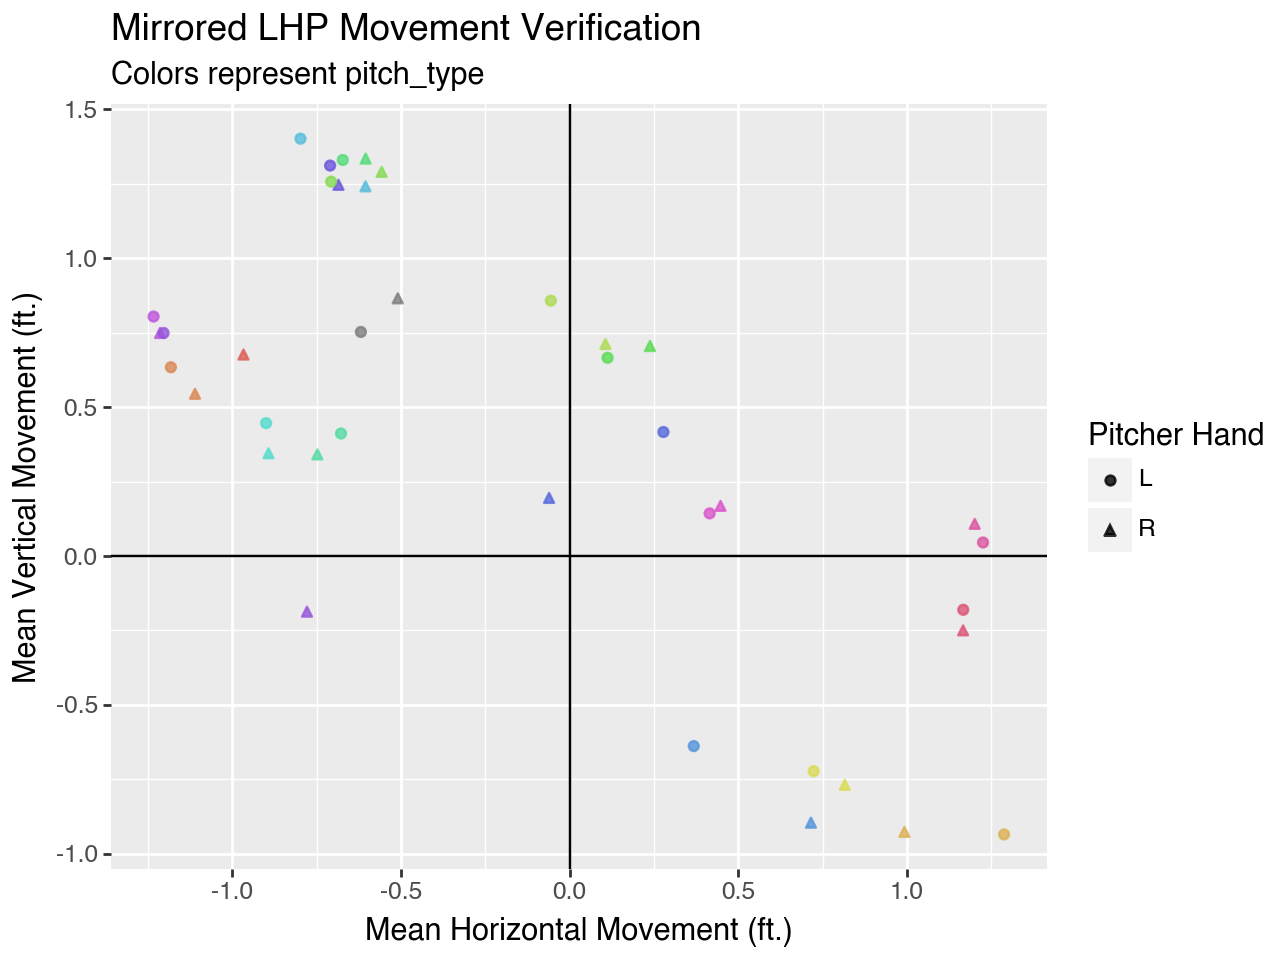

In [5]:
mirrored_pitches_df = (
    pitches_run_value_df
    .with_columns([
        # mirror LHP horizontal movement
        pl.when(pl.col("p_throws") == "L")
        .then(-pl.col("pfx_x"))
        .otherwise(pl.col("pfx_x")),
    ])
)

# for verification
movement_plt = (
    ggplot(
        mirrored_pitches_df
        .group_by("pitch_type", "p_throws")
        .agg(
            pl.col("pfx_x").mean().alias("mean_pfx_x"),
            pl.col("pfx_z").mean().alias("mean_pfx_z"),
        ).collect(),
        aes(x="mean_pfx_x", y="mean_pfx_z", color="pitch_type", shape="p_throws"))
    + geom_point(alpha=0.8)
    + geom_vline(xintercept=0)
    + geom_hline(yintercept=0)
    + guides(color="none")
    + labs(
        title="Mirrored LHP Movement Verification",
        x="Mean Horizontal Movement (ft.)",
        y="Mean Vertical Movement (ft.)",
        shape="Pitcher Hand",
        subtitle="Colors represent pitch_type",
    )
)

movement_plt.show()

Horizontal movement profiles are mirrored now! Next step is to add `tunnel_score`

In [6]:
def add_tunnel_score():
    ...


Now adding the rest of the features